In [1]:
import matplotlib.pyplot as plt
import matplotlib
import logging as logger
import numpy as np
import os
import sys
from astropy.table import Table
from time import time
from collections import OrderedDict

sys.path.insert(0, "../")

from mcfa.mcfa import MCFA

%matplotlib inline

In [2]:
barklem_abundances = Table.read("../catalogs/barklem_t3.fits")


In [3]:
barklem_abundances

Name,El,logEpsX,e_logEpsX,e_logepsx_lc,__X_Fe_,e__X_Fe_,e__x_fe__lc,N,N3
,,[---],[---],[---],[---],[---],[---],,
str13,str2,float32,float32,float32,float32,float32,float32,int16,int16
CS 22175-007,Al,2.54,0.17,0.25,-1.12,0.18,0.26,1,1
CS 22175-007,Ba,-1.15,0.21,0.25,-0.47,0.18,0.26,2,1
CS 22175-007,C,5.77,0.19,0.26,0.19,0.18,0.27,1,1
CS 22175-007,Ca,3.87,0.12,0.2,0.31,0.15,0.25,9,5
CS 22175-007,Ce,nan,nan,nan,nan,nan,nan,10,0
CS 22175-007,Co,2.35,0.15,0.22,0.24,0.15,0.24,6,4
CS 22175-007,Cr,2.52,0.17,0.24,-0.35,0.16,0.24,3,3
CS 22175-007,Eu,nan,nan,nan,nan,nan,nan,4,0


In [4]:
# Solar abundances.
asplund_2009 = {
    "Pr": 0.72, 
    "Ni": 6.22, 
    "Gd": 1.07, 
    "Pd": 1.57, 
    "Pt": 1.62, 
    "Ru": 1.75, 
    "S": 7.12, 
    "Na": 6.24, 
    "Nb": 1.46, 
    "Nd": 1.42, 
    "Mg": 7.6, 
    "Li": 1.05, 
    "Pb": 1.75, 
    "Re": 0.26, 
    "Tl": 0.9, 
    "Tm": 0.1, 
    "Rb": 2.52, 
    "Ti": 4.95, 
    "As": 2.3, 
    "Te": 2.18, 
    "Rh": 0.91, 
    "Ta": -0.12, 
    "Be": 1.38, 
    "Xe": 2.24, 
    "Ba": 2.18, 
    "Tb": 0.3, 
    "H": 12.0, 
    "Yb": 0.84, 
    "Bi": 0.65, 
    "W": 0.85, 
    "Ar": 6.4, 
    "Fe": 7.5, 
    "Br": 2.54, 
    "Dy": 1.1, 
    "Hf": 0.85, 
    "Mo": 1.88, 
    "He": 10.93, 
    "Cl": 5.5, 
    "C": 8.43, 
    "B": 2.7, 
    "F": 4.56, 
    "I": 1.55, 
    "Sr": 2.87, 
    "K": 5.03, 
    "Mn": 5.43, 
    "O": 8.69, 
    "Ne": 7.93, 
    "P": 5.41, 
    "Si": 7.51, 
    "Th": 0.02, 
    "U": -0.54, 
    "Sn": 2.04, 
    "Sm": 0.96, 
    "V": 3.93, 
    "Y": 2.21, 
    "Sb": 1.01, 
    "N": 7.83, 
    "Os": 1.4, 
    "Se": 3.34, 
    "Sc": 3.15, 
    "Hg": 1.17, 
    "Zn": 4.56, 
    "La": 1.1, 
    "Ag": 0.94, 
    "Kr": 3.25, 
    "Co": 4.99, 
    "Ca": 6.34, 
    "Ir": 1.38, 
    "Eu": 0.52, 
    "Al": 6.45, 
    "Ce": 1.58, 
    "Cd": 1.71, 
    "Ho": 0.48, 
    "Ge": 3.65, 
    "Lu": 0.1, 
    "Au": 0.92, 
    "Zr": 2.58, 
    "Ga": 3.04, 
    "In": 0.8, 
    "Cs": 1.08, 
    "Cr": 5.64, 
    "Cu": 4.19, 
    "Er": 0.92
}
solar_abundance = asplund_2009

In [5]:
def atomic_number(element):
    periodic_table = """H                                                  He
                        Li Be                               B  C  N  O  F  Ne
                        Na Mg                               Al Si P  S  Cl Ar
                        K  Ca Sc Ti V  Cr Mn Fe Co Ni Cu Zn Ga Ge As Se Br Kr
                        Rb Sr Y  Zr Nb Mo Tc Ru Rh Pd Ag Cd In Sn Sb Te I  Xe
                        Cs Ba Lu Hf Ta W  Re Os Ir Pt Au Hg Tl Pb Bi Po At Rn
                        Fr Ra Lr Rf Db Sg Bh Hs Mt Ds Rg Cn UUt"""
    
    lanthanoids    =   "La Ce Pr Nd Pm Sm Eu Gd Tb Dy Ho Er Tm Yb"
    actinoids      =   "Ac Th Pa U  Np Pu Am Cm Bk Cf Es Fm Md No"
    
    periodic_table = periodic_table.replace(" Ba ", " Ba " + lanthanoids + " ") \
        .replace(" Ra ", " Ra " + actinoids + " ").split()
    
    return periodic_table.index(element.strip().title()) - 1


In [6]:
# Re-structure the data.
def restructure_barklem_data(data):
    
    parse_element = lambda x: x.strip().lower()
    
    unique_names = np.sort(np.unique(data["Name"]))
    unique_elements = np.sort(np.unique([parse_element(el) for el in data["El"]]))
    N, E = len(unique_names), len(unique_elements)
    
    restructured_data = OrderedDict(name=unique_names)
    for element in unique_elements:
        restructured_data.setdefault(f"{element}_h", np.nan * np.ones(N))
        restructured_data.setdefault(f"{element}_h_err_rel", np.nan * np.ones(N))
        restructured_data.setdefault(f"{element}_h_err_abs", np.nan * np.ones(N))

    for group in data.group_by("Name").groups:
        index = np.where(group["Name"][0] == unique_names)[0][0]
        for row in group:
            element = parse_element(row["El"])
            restructured_data[f"{element}_h"][index] = row["logEpsX"] - solar_abundance[row["El"].strip()]
            restructured_data[f"{element}_h_err_rel"][index] = row["e_logEpsX"]
            restructured_data[f"{element}_h_err_abs"][index] = row["e_logepsx_lc"]
    
    return Table(data=restructured_data)
        

In [7]:
data = restructure_barklem_data(barklem_abundances)

In [8]:
data

name,al_h,al_h_err_rel,al_h_err_abs,ba_h,ba_h_err_rel,ba_h_err_abs,c_h,c_h_err_rel,c_h_err_abs,ca_h,ca_h_err_rel,ca_h_err_abs,ce_h,ce_h_err_rel,ce_h_err_abs,co_h,co_h_err_rel,co_h_err_abs,cr_h,cr_h_err_rel,cr_h_err_abs,eu_h,eu_h_err_rel,eu_h_err_abs,fe_h,fe_h_err_rel,fe_h_err_abs,la_h,la_h_err_rel,la_h_err_abs,mg_h,mg_h_err_rel,mg_h_err_abs,mn_h,mn_h_err_rel,mn_h_err_abs,nd_h,nd_h_err_rel,nd_h_err_abs,ni_h,ni_h_err_rel,ni_h_err_abs,sc_h,sc_h_err_rel,sc_h_err_abs,sm_h,sm_h_err_rel,sm_h_err_abs,sr_h,sr_h_err_rel,sr_h_err_abs,ti_h,ti_h_err_rel,ti_h_err_abs,v_h,v_h_err_rel,v_h_err_abs,y_h,y_h_err_rel,y_h_err_abs,zn_h,zn_h_err_rel,zn_h_err_abs,zr_h,zr_h_err_rel,zr_h_err_abs
str13,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
CS 22175-007,-3.910000038146973,0.17000000178813934,0.25,-3.3299999761581422,0.20999999344348907,0.25,-2.660000019073486,0.1899999976158142,0.25999999046325684,-2.470000114440918,0.11999999731779099,0.20000000298023224,nan,nan,nan,-2.640000095367432,0.15000000596046448,0.2199999988079071,-3.120000019073486,0.17000000178813934,0.23999999463558197,nan,nan,nan,-2.809999942779541,0.12999999523162842,0.18000000715255737,nan,nan,nan,-2.449999904632568,0.11999999731779099,0.18000000715255737,-3.5899999666213986,0.17000000178813934,0.2199999988079071,nan,nan,nan,-2.519999952316284,0.20000000298023224,0.30000001192092896,-2.6599999904632567,0.18000000715255737,0.23000000417232513,nan,nan,nan,-2.5399999868869783,0.20000000298023224,0.30000001192092896,-2.390000057220459,0.17000000178813934,0.2199999988079071,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CS 22186-023,-3.6700000286102297,0.15000000596046448,0.23999999463558197,-3.699999980926514,0.1899999976158142,0.23000000417232513,-2.4600002098083493,0.1899999976158142,0.25,-2.570000019073486,0.11999999731779099,0.20000000298023224,nan,nan,nan,-2.6600000762939455,0.1599999964237213,0.2199999988079071,-2.9599999332427975,0.1599999964237213,0.25,nan,nan,nan,-2.7199997901916504,0.12999999523162842,0.18000000715255737,nan,nan,nan,-2.6100002288818356,0.11999999731779099,0.18000000715255737,-3.160000019073486,0.15000000596046448,0.20999999344348907,nan,nan,nan,-2.6600000572204587,0.17000000178813934,0.2800000011920929,-2.6899999916553496,0.17000000178813934,0.23000000417232513,nan,nan,nan,-2.769999998509884,0.1899999976158142,0.30000001192092896,-2.509999942779541,0.1599999964237213,0.20999999344348907,nan,nan,nan,-3.099999985694885,0.18000000715255737,0.23000000417232513,nan,nan,nan,nan,nan,nan
CS 22186-025,-3.850000095367432,0.20999999344348907,0.27000001072883606,-2.7699999737739565,0.23999999463558197,0.3100000023841858,-3.600000076293945,0.20000000298023224,0.27000001072883606,-2.59,0.11999999731779099,0.20000000298023224,nan,nan,nan,-2.7300000095367434,0.15000000596046448,0.2199999988079071,-3.2900000953674313,0.1599999964237213,0.23000000417232513,nan,nan,nan,-2.869999885559082,0.14000000059604645,0.1899999976158142,nan,nan,nan,-2.6100002288818356,0.11999999731779099,0.18000000715255737,-3.579999976158142,0.1599999964237213,0.20999999344348907,nan,nan,nan,-3.1000001144409177,0.1899999976158142,0.25,-2.7100000023841857,0.18000000715255737,0.23000000417232513,nan,nan,nan,-3.0700000029802323,0.25,0.3499999940395355,-2.5499999046325685,0.15000000596046448,0.20000000298023224,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
CS 22886-042,-3.7499999523162844,0.17000000178813934,0.25999999046325684,-2.8500000166893007,0.23999999463558197,0.3100000023841858,-2.7100002098083493,0.1899999976158142,0.259999

In [9]:
data.dtype.names

('name',
 'al_h',
 'al_h_err_rel',
 'al_h_err_abs',
 'ba_h',
 'ba_h_err_rel',
 'ba_h_err_abs',
 'c_h',
 'c_h_err_rel',
 'c_h_err_abs',
 'ca_h',
 'ca_h_err_rel',
 'ca_h_err_abs',
 'ce_h',
 'ce_h_err_rel',
 'ce_h_err_abs',
 'co_h',
 'co_h_err_rel',
 'co_h_err_abs',
 'cr_h',
 'cr_h_err_rel',
 'cr_h_err_abs',
 'eu_h',
 'eu_h_err_rel',
 'eu_h_err_abs',
 'fe_h',
 'fe_h_err_rel',
 'fe_h_err_abs',
 'la_h',
 'la_h_err_rel',
 'la_h_err_abs',
 'mg_h',
 'mg_h_err_rel',
 'mg_h_err_abs',
 'mn_h',
 'mn_h_err_rel',
 'mn_h_err_abs',
 'nd_h',
 'nd_h_err_rel',
 'nd_h_err_abs',
 'ni_h',
 'ni_h_err_rel',
 'ni_h_err_abs',
 'sc_h',
 'sc_h_err_rel',
 'sc_h_err_abs',
 'sm_h',
 'sm_h_err_rel',
 'sm_h_err_abs',
 'sr_h',
 'sr_h_err_rel',
 'sr_h_err_abs',
 'ti_h',
 'ti_h_err_rel',
 'ti_h_err_abs',
 'v_h',
 'v_h_err_rel',
 'v_h_err_abs',
 'y_h',
 'y_h_err_rel',
 'y_h_err_abs',
 'zn_h',
 'zn_h_err_rel',
 'zn_h_err_abs',
 'zr_h',
 'zr_h_err_rel',
 'zr_h_err_abs')

In [10]:
elements = [ea for ea in data.dtype.names if ea.endswith("_h")]

In [11]:
elements

['al_h',
 'ba_h',
 'c_h',
 'ca_h',
 'ce_h',
 'co_h',
 'cr_h',
 'eu_h',
 'fe_h',
 'la_h',
 'mg_h',
 'mn_h',
 'nd_h',
 'ni_h',
 'sc_h',
 'sm_h',
 'sr_h',
 'ti_h',
 'v_h',
 'y_h',
 'zn_h',
 'zr_h']

In [12]:
X = np.array([data[el] for el in elements]).T

In [13]:
X.shape

(253, 22)

In [14]:
np.sum(np.all(np.isfinite(X), axis=1))

6

In [15]:
finites = dict()
for element in elements:
    finites[element] = np.sum(np.isfinite(data[element]))
finites

{'al_h': 239,
 'ba_h': 220,
 'c_h': 249,
 'ca_h': 253,
 'ce_h': 13,
 'co_h': 223,
 'cr_h': 248,
 'eu_h': 68,
 'fe_h': 253,
 'la_h': 33,
 'mg_h': 245,
 'mn_h': 237,
 'nd_h': 35,
 'ni_h': 247,
 'sc_h': 247,
 'sm_h': 9,
 'sr_h': 245,
 'ti_h': 250,
 'v_h': 47,
 'y_h': 154,
 'zn_h': 38,
 'zr_h': 48}

In [16]:
sorted_finites = sorted(finites.items(), key=lambda x:x[1])[::-1]
for k, v in sorted_finites:
    print(k, v)

fe_h 253
ca_h 253
ti_h 250
c_h 249
cr_h 248
sc_h 247
ni_h 247
sr_h 245
mg_h 245
al_h 239
mn_h 237
co_h 223
ba_h 220
y_h 154
eu_h 68
zr_h 48
v_h 47
zn_h 38
nd_h 35
la_h 33
ce_h 13
sm_h 9


In [17]:
D = 15

In [18]:
use_elements = [k for k, v in sorted_finites][:D]

In [19]:
use_elements

['fe_h',
 'ca_h',
 'ti_h',
 'c_h',
 'cr_h',
 'sc_h',
 'ni_h',
 'sr_h',
 'mg_h',
 'al_h',
 'mn_h',
 'co_h',
 'ba_h',
 'y_h',
 'eu_h']

In [20]:
idx = np.argsort(np.array([atomic_number(ln.split("_")[0]) for ln in use_elements]))
label_names = [use_elements[i] for i in idx]

X = np.array([data[ln] for ln in label_names]).T

In [21]:
keep = np.all(np.isfinite(X), axis=1)
X = X[keep]

In [22]:
X.shape

(61, 15)

In [23]:
model = MCFA(n_components=1, n_latent_factors=3)
model.fit(X)

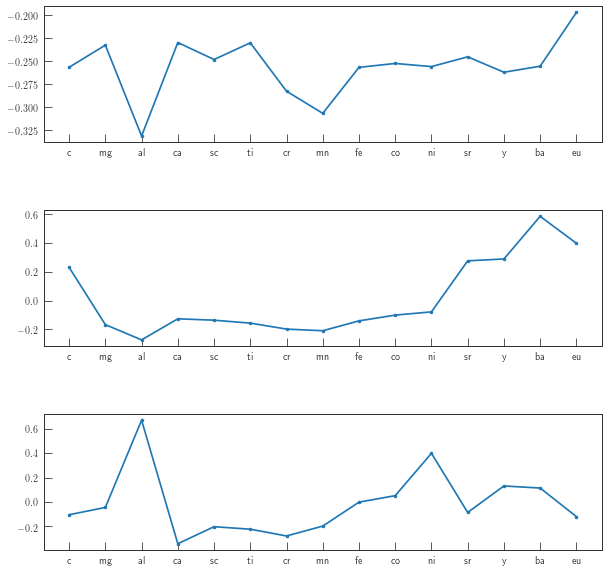

In [24]:

latex_labels = dict()
                               
A = model.theta_[model.parameter_names.index("A")]

fig, axes = plt.subplots(model.n_latent_factors, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.plot(A.T[i])
    ax.set_xticks(np.arange(D))
    ax.set_xticklabels([ln.split("_")[0] for ln in label_names])


In [25]:
N, D = X.shape

print(N,D)

# Do some grid search in J, K
Js = np.arange(1, 10 + 1).astype(int)
Ks = np.arange(1, 10 + 1).astype(int)

BICs = np.nan * np.ones((Js.size, Ks.size))
opt_times = np.nan * np.ones((Js.size, Ks.size))
log_likelihoods = np.nan * np.ones((Js.size, Ks.size))

write_results = False
results_path = "results/barklem-gridsearch-J{J}-K{K}.pkl"

results_folder = os.path.dirname(results_path)
if not os.path.exists(results_folder):
    os.mkdir(results_folder)

mcfa_kwds = dict(max_iter=1000, n_init=5, tol=1e-5, verbose=0,
                 random_seed=None)

c, C = (0, Js.size * Ks.size)

for k, K in enumerate(Ks):
    for j, J in enumerate(Js):
        
        c += 1
        print("{}/{}: J = {}, K = {}".format(c, C, J, K))
        if np.isfinite(BICs[j, k]):
            print("Skipping..")
            continue
        
        kwds = mcfa_kwds.copy()
        kwds.update(n_components=K, n_latent_factors=J)
        
        model = MCFA(**kwds)
        
        t_init = time()
        try:
            model.fit(X)
            
        except:
            logger.exception("Exception in fitting at J = {}, K = {}".format(J, K))
            opt_times[j, k] = np.nan
            BICs[j, k] = np.nan
            log_likelihoods[j, k] = np.nan
            continue
            
        t_opt = time() - t_init
        
        # Save results.
        opt_times[j, k] = t_opt
        BICs[j, k] = model.bic(X)
        log_likelihoods[j, k] = model.log_likelihood_                     
        
        if write_results:
            result = dict(kwds=kwds,
                          t_opt=t_opt,
                          bic=BICs[j, k],
                          tau=model.tau_,
                          theta=model.theta_,
                          n_iter=model.n_iter_, 
                          log_likelihood=model.log_likelihood_)
            
            path = results_path.format(J=J, K=K)
            with open(path, "wb") as fp:
                pickle.dump(result, fp, -1)

            print("Results written to {}".format(path))



61 15
1/100: J = 1, K = 1
2/100: J = 2, K = 1
3/100: J = 3, K = 1
4/100: J = 4, K = 1
5/100: J = 5, K = 1
6/100: J = 6, K = 1
7/100: J = 7, K = 1
8/100: J = 8, K = 1
9/100: J = 9, K = 1
10/100: J = 10, K = 1
11/100: J = 1, K = 2
12/100: J = 2, K = 2
13/100: J = 3, K = 2
14/100: J = 4, K = 2
15/100: J = 5, K = 2
16/100: J = 6, K = 2
17/100: J = 7, K = 2
18/100: J = 8, K = 2
19/100: J = 9, K = 2
20/100: J = 10, K = 2
21/100: J = 1, K = 3
22/100: J = 2, K = 3
23/100: J = 3, K = 3
24/100: J = 4, K = 3
25/100: J = 5, K = 3
26/100: J = 6, K = 3
27/100: J = 7, K = 3


ERROR:root:Exception in fitting at J = 7, K = 3
Traceback (most recent call last):
  File "<ipython-input-25-1cef4ec81d64>", line 41, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 422, in fit
    converged, prev_ll, ratio = self._check_convergence(prev_ll, ll)
  File "../mcfa/mcfa.py", line 384, in _check_convergence
    assert current > previous # depends on objective function
AssertionError


28/100: J = 8, K = 3
29/100: J = 9, K = 3
30/100: J = 10, K = 3
31/100: J = 1, K = 4
32/100: J = 2, K = 4
33/100: J = 3, K = 4
34/100: J = 4, K = 4
35/100: J = 5, K = 4
36/100: J = 6, K = 4
37/100: J = 7, K = 4
38/100: J = 8, K = 4
39/100: J = 9, K = 4
40/100: J = 10, K = 4
41/100: J = 1, K = 5
42/100: J = 2, K = 5
43/100: J = 3, K = 5
44/100: J = 4, K = 5
45/100: J = 5, K = 5


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.993984e-18
  W = linalg.solve(omega[:, :, i], I_J)


46/100: J = 6, K = 5


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.793933e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.438378e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.818160e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.414136e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.244440

47/100: J = 7, K = 5


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.208641e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.131942e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.584031e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.258663e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.843261

48/100: J = 8, K = 5


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.433620e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.185956e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.613370e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.987450e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.256086

49/100: J = 9, K = 5


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.793286e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.064268e-16
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.056548e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.540762e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.

50/100: J = 10, K = 5


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.206440e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.135678e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.775902e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.539555e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.

51/100: J = 1, K = 6


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.930864e-18
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 2, K = 6
Traceback (most recent call last):
  File "<ipython-input-25-1cef4ec81d64>", line 41, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 419, in fit
    theta = self.maximization(X, tau, *theta)
  File "../mcfa/mcfa.py", line 337, in maximization
    W = linalg.solve(omega[:, :, i], I_J)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 216, in solve
    _solve_check(n, info)
  File "/home/acas0005/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py", line 31, in _solve_check
    raise LinAlgError('Matrix is singular.')
numpy.linalg.linalg.LinAlgError: Matrix is singular.


52/100: J = 2, K = 6
53/100: J = 3, K = 6


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.099484e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.605586e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.934706e-17
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 3, K = 6
Traceback (most recent call last):
  File "<ipython-input-25-1cef4ec81d64>", line 41, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 419, in fit
    theta = self.maximization(X, tau, *theta)
  File "../mcfa/mcfa.py", line 337, in maximization
    W = linalg.solve(omega[:, :, i], I_J)
  File "/home/acas0005/anac

54/100: J = 4, K = 6
55/100: J = 5, K = 6


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.202004e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.999970e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.436047e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.832464e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.424233

56/100: J = 6, K = 6
57/100: J = 7, K = 6


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.600975e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.239434e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.779889e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.032377e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.300084

58/100: J = 8, K = 6
59/100: J = 9, K = 6


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.469161e-20
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.433014e-19
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.530603e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.623196e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.

60/100: J = 10, K = 6
61/100: J = 1, K = 7
62/100: J = 2, K = 7


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.869363e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.869363e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.173873e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.152143e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.014310

63/100: J = 3, K = 7


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.224096e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.046761e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.046761e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.444197e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.537208

64/100: J = 4, K = 7


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.150916e-17
  W = linalg.solve(omega[:, :, i], I_J)


65/100: J = 5, K = 7


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.444925e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.217178e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.032761e-20
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.957710e-18
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.916

66/100: J = 6, K = 7
67/100: J = 7, K = 7


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.954736e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.805514e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.951157e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.532153e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.646568

68/100: J = 8, K = 7
69/100: J = 9, K = 7


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.429312e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.284480e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.629960e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.226284e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.

70/100: J = 10, K = 7
71/100: J = 1, K = 8
72/100: J = 2, K = 8


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.869363e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.760809e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.869363e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.760809e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.878179

73/100: J = 3, K = 8


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.025175e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.938539e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.735305e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.093521e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.518421

74/100: J = 4, K = 8


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.301304e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.554959e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.932797e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
ERROR:root:Exception in fitting at J = 4, K = 8
Traceback (most recent call last):
  File "<ipython-input-25-1cef4ec81d64>", line 41, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 410, in fit
    theta = self._initial_parameters(X) if init_params is None \
  File "../mcfa/mcfa.py", line 151, in _initial_parameters
    raise ValueError("no initialisation 

75/100: J = 5, K = 8


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.377970e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.432179e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.036683e-20
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.217129e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.534

76/100: J = 6, K = 8


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.867044e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.433672e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.406986e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.436047e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.340

77/100: J = 7, K = 8


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.604879e-20
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.140245e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.287324e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.318338e-20
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.739

78/100: J = 8, K = 8


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.094585e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.301152e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.692673e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.168046e-20
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.550

79/100: J = 9, K = 8


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.905813e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.575786e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Re

80/100: J = 10, K = 8


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.241388e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.031665e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.324543e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.003780e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.

81/100: J = 1, K = 9


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.644924e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.173873e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

82/100: J = 2, K = 9
83/100: J = 3, K = 9


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.093521e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.917059e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.010953e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.853931e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.194665

../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not gu

84/100: J = 4, K = 9
85/100: J = 5, K = 9


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.526374e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.003610e-20
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.519653e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.578666e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.764

86/100: J = 6, K = 9
87/100: J = 7, K = 9


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.137086e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.462296e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.562728e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.118461e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.

88/100: J = 8, K = 9


../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.547392e-18
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.993588e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.664542e-18
  W = linalg.solve(omega[:, :, i], I_J)
ERROR:root:Exception in fitting at J = 8, K = 9
Traceback (most recent call last):
  File "<ipython-input-25-1cef4ec81d64>", line 41, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 410, in fit
    theta = self._initial_parameters(X) if init_params is None \
  File "../mcfa/mcfa.py", line 151, in _initial_parameters
    raise ValueError("no initialisation 

89/100: J = 9, K = 9


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.363563e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.488110e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Re

90/100: J = 10, K = 9
91/100: J = 1, K = 10
92/100: J = 2, K = 10


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.644924e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.869363e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/py

93/100: J = 3, K = 10


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.046761e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.025175e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.043810e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.938539e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.046761

94/100: J = 4, K = 10


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.402490e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.177544e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

95/100: J = 5, K = 10


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.764821e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.463975e-18
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib

96/100: J = 6, K = 10


../mcfa/mcfa.py:606: RuntimeWarning: Degrees of freedom <= 0 for slice
  omega[:, :, i] = np.cov(xs.T)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/home/acas0005/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3109: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.215367e-17
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.739212e-20
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Recip

97/100: J = 7, K = 10


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.715693e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.650784e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.080126e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.137086e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.446034

98/100: J = 8, K = 10


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.027644e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.968041e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.634798e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.605972e-18
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.

99/100: J = 9, K = 10


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.431561e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.363493e-18
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.015634e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.860758e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.

../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.410680e-19
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number8.210034e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number2.771674e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
ERROR:root:Exception in fitting at J = 9, K = 10
Traceback (most recent call last):
  File "<ipython-input-25-1cef4ec81d64>", line 41, in <module>
    model.fit(X)
  File "../mcfa/mcfa.py", line 419, in fit
    theta = self.maximization(X, tau, *theta)
  File "../mcfa/mcfa.py", line 337, in maximization
    W = linalg.solve(omega[:, :, i], I_J)
  File "/home/acas00

100/100: J = 10, K = 10


../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.668948e-18
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.539785e-17
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.428801e-19
  W = linalg.solve(omega[:, :, i], I_J)
../mcfa/mcfa.py:338: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.728923e-18
  C = linalg.solve(W + A.T @ inv_D_A, I_J)
../mcfa/mcfa.py:337: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.

In [26]:
def scatter_grid_search(Js, Ks, Zs, z_percentiles=None, cbar_label=None,
                        figsize=(10, 10), highlight_z_index=None, **kwargs):

    Jm, Km = np.meshgrid(Js, Ks)
    x, y = (Jm.flatten(), Km.flatten())
    z = Zs.T.flatten()

    kwds = dict(s=10, cmap="viridis")
    if z_percentiles is not None:
        vmin, vmax = np.nanpercentile(z, z_percentiles)
        kwds.update(vmin=vmin, vmax=vmax)
    
    kwds.update(kwargs)
    
    fig, ax = plt.subplots(figsize=figsize)
    scat = ax.scatter(x, y, c=z, **kwds)
    
    ax.set_xlabel(r"$J$")
    ax.set_ylabel(r"$K$")
    
    if cbar_label is not None:
        cbar = plt.colorbar(scat)
        cbar.set_label(cbar_label)
        
    ax.set_xticks(np.unique(x).astype(int))
    ax.set_xticklabels(np.unique(x).astype(str))
    
    if highlight_z_index is not None:
        ok = np.where(np.isfinite(z))[0]
        
        indices = ok[np.argsort(z[ok])][highlight_z_index]
        ax.scatter(x[indices], y[indices], zorder=-1,
                   s=100, lw=5, edgecolor="r", facecolor="none")
        
    
    fig.tight_layout()
    return fig


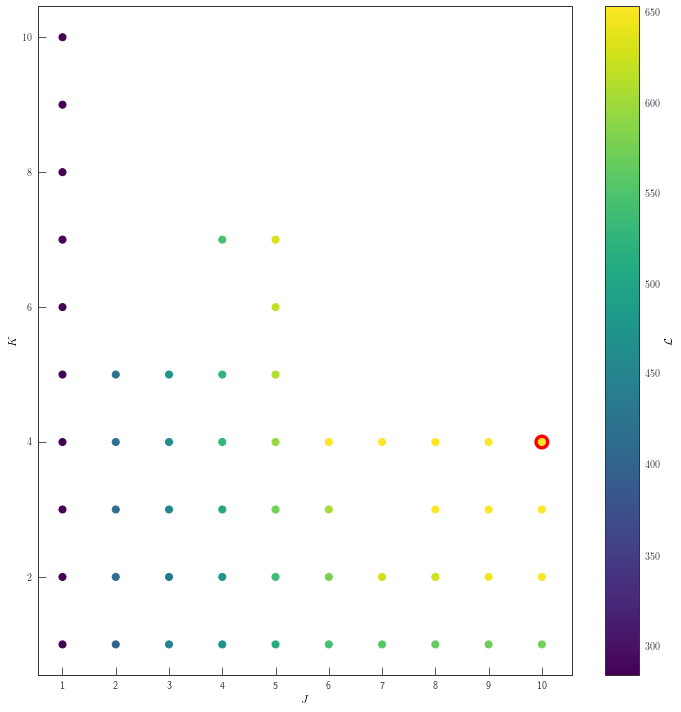

In [27]:
fig = scatter_grid_search(Js, Ks, log_likelihoods, s=50,
                          z_percentiles=[16, 84], cbar_label=r"$\mathcal{L}$",
                          highlight_z_index=-1)

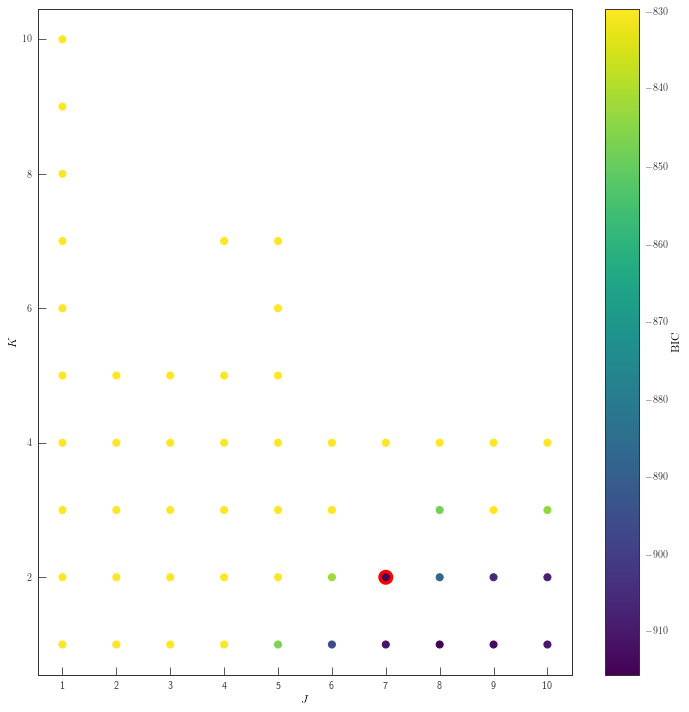

In [62]:
fig = scatter_grid_search(Js, Ks, BICs, s=50,
                          z_percentiles=[1, 25], cbar_label=r"\textrm{BIC}",
                          highlight_z_index=0)

In [30]:
model = MCFA(n_components=2, n_latent_factors=7, **mcfa_kwds)
model.fit(X)

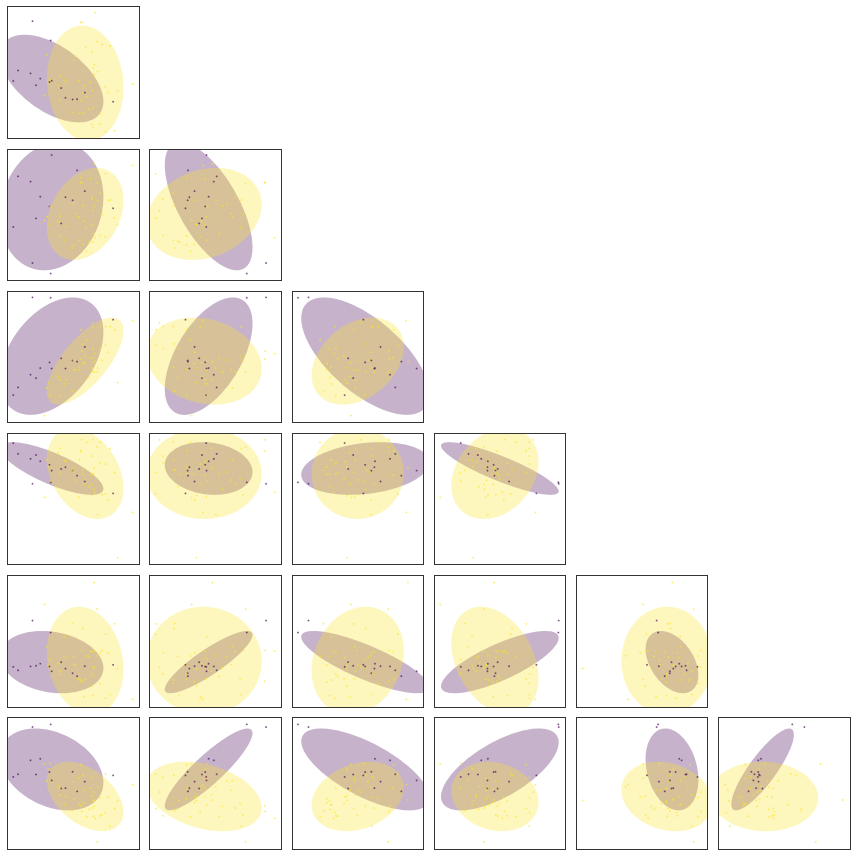

In [32]:
fig = model.plot_latent_space(X)

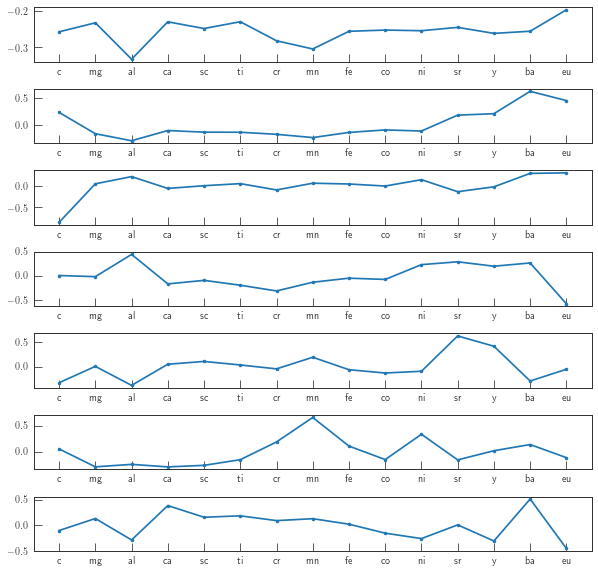

In [33]:

latex_labels = dict()
                               
A = model.theta_[model.parameter_names.index("A")]

fig, axes = plt.subplots(model.n_latent_factors, figsize=(10, 10))
for i, ax in enumerate(axes):
    ax.plot(A.T[i])
    ax.set_xticks(np.arange(D))
    ax.set_xticklabels([ln.split("_")[0] for ln in label_names])


[Text(0,0,'c'),
 Text(0,0,'mg'),
 Text(0,0,'al'),
 Text(0,0,'ca'),
 Text(0,0,'sc'),
 Text(0,0,'ti'),
 Text(0,0,'cr'),
 Text(0,0,'mn'),
 Text(0,0,'fe'),
 Text(0,0,'co'),
 Text(0,0,'ni'),
 Text(0,0,'sr'),
 Text(0,0,'y'),
 Text(0,0,'ba'),
 Text(0,0,'eu')]

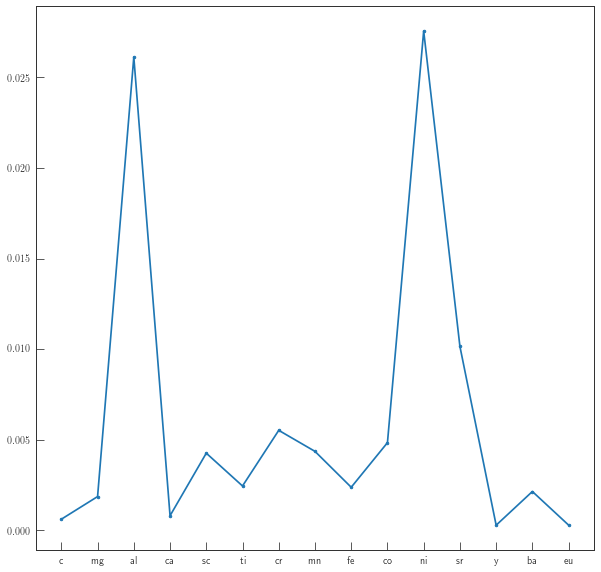

In [37]:
psi_index = model.parameter_names.index("psi")
psi = model.theta_[psi_index]

fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(psi)
ax.set_xticks(np.arange(D))
ax.set_xticklabels([ln.split("_")[0] for ln in label_names])

In [35]:
psi.shape

(15,)

In [48]:
X_err_rel = np.array([data[f"{ln}_err_rel"] for ln in label_names]).T[keep]
X_err_abs = np.array([data[f"{ln}_err_abs"] for ln in label_names]).T[keep]

[Text(0,0,'c'),
 Text(0,0,'mg'),
 Text(0,0,'al'),
 Text(0,0,'ca'),
 Text(0,0,'sc'),
 Text(0,0,'ti'),
 Text(0,0,'cr'),
 Text(0,0,'mn'),
 Text(0,0,'fe'),
 Text(0,0,'co'),
 Text(0,0,'ni'),
 Text(0,0,'sr'),
 Text(0,0,'y'),
 Text(0,0,'ba'),
 Text(0,0,'eu')]

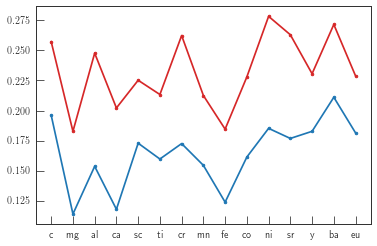

In [49]:
fig, ax = plt.subplots()
ax.plot(np.mean(X_err_rel, axis=0), c="tab:blue")
ax.plot(np.mean(X_err_abs, axis=0), c="tab:red")
ax.set_xticks(np.arange(D))
ax.set_xticklabels([ln.split("_")[0] for ln in label_names])

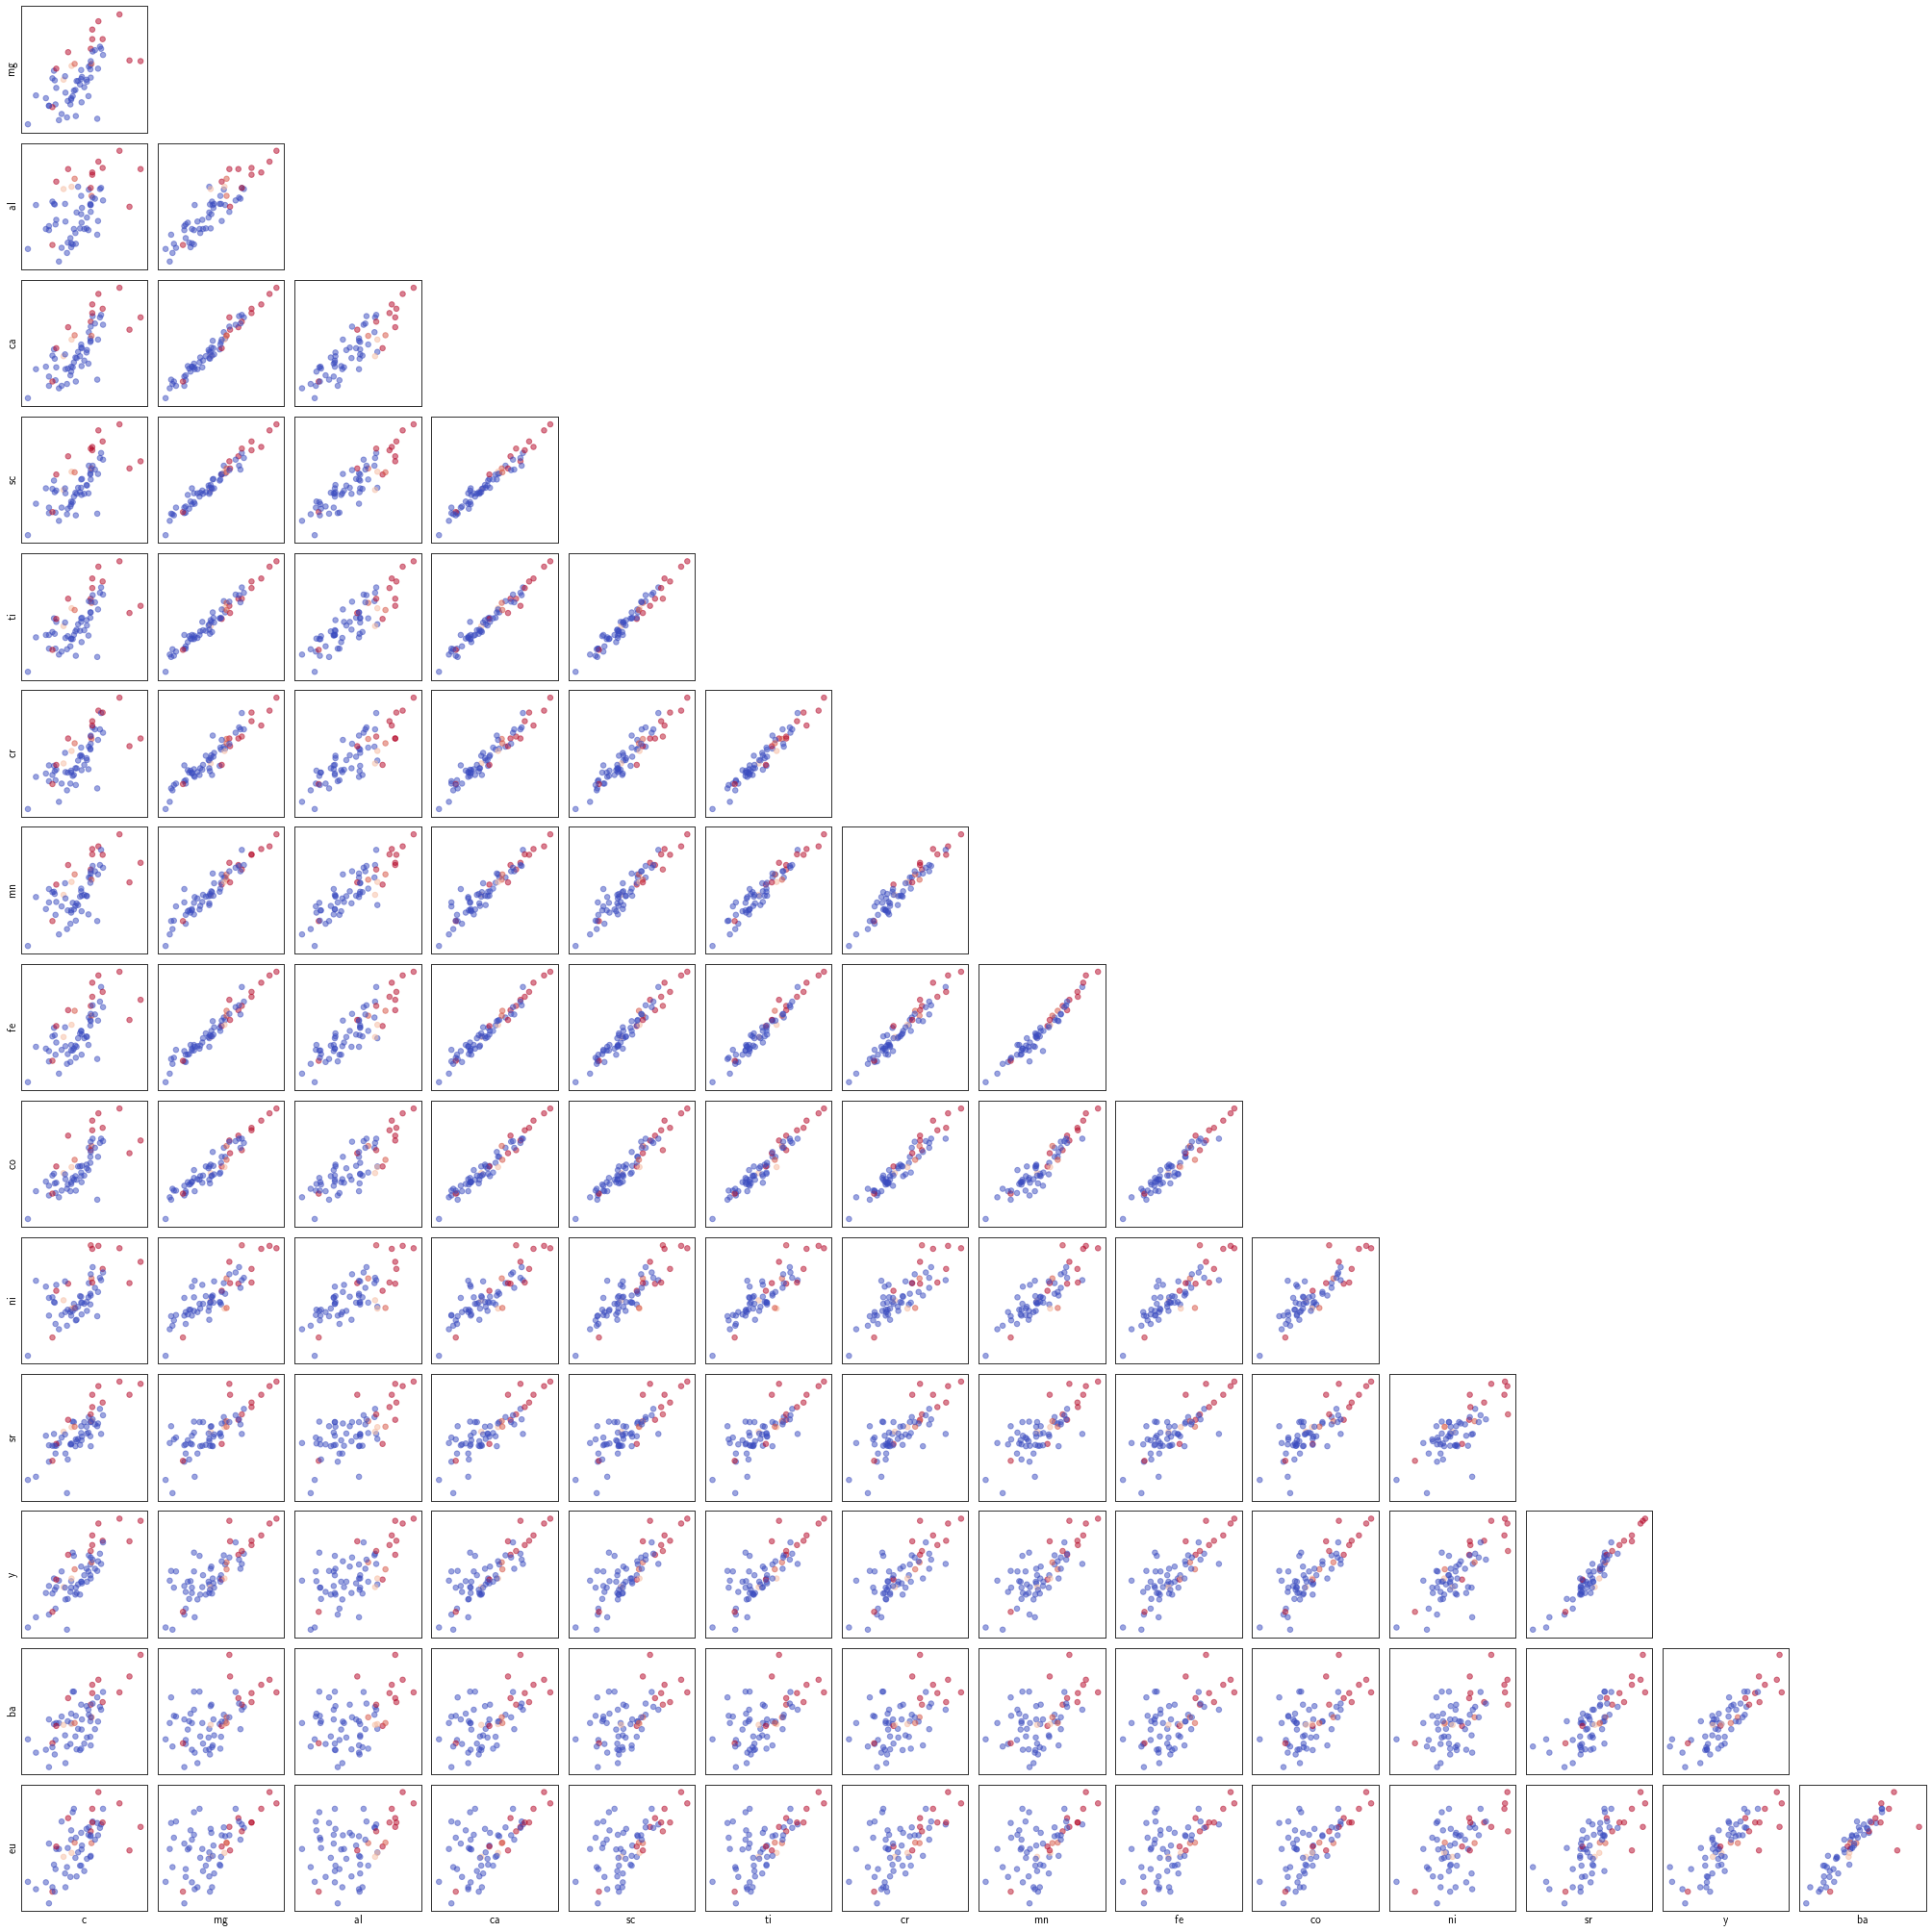

In [56]:
from mcfa import mpl_utils
fig = mpl_utils.corner_scatter(X, c=model.tau_.T[0], s=30, cmap="coolwarm",
                               label_names=[ln.split("_")[0] for ln in label_names])
